In [ ]:
import pandas as pd
import csv

# Load the dataset
df = pd.read_csv('online_retail.csv')

# Remove missing customers
df = df.dropna(subset=['Customer ID'])

# Convert 'Customer Id' to integer
df['Customer ID'] = df['Customer ID'].astype(int)

# Remove canceled orders
df = df[~df['Invoice'].str.startswith('C')]

# Remove rows where item price was '0'
df = df[df['Price'] > 0]

# Remove non-product stock codes
# List of non-product codes
non_product_codes = ['POST', 'DOT', 'ADJUST', 'C2', 'M', 'BANK CHARGES']

# Keep only rows where StockCode is NOT in the list
df = df[~df['StockCode'].isin(non_product_codes)]

# Create 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract Year, Month, DayOfWeek, Hour:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Save the cleaned dataset to a new CSV file
df.to_csv('online_retail_cleaned.csv', index=False)

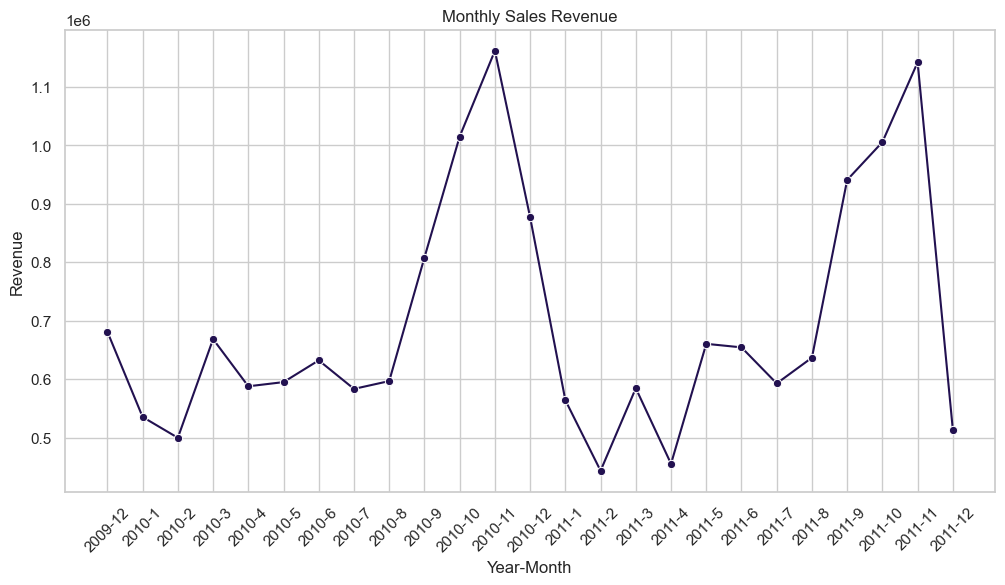

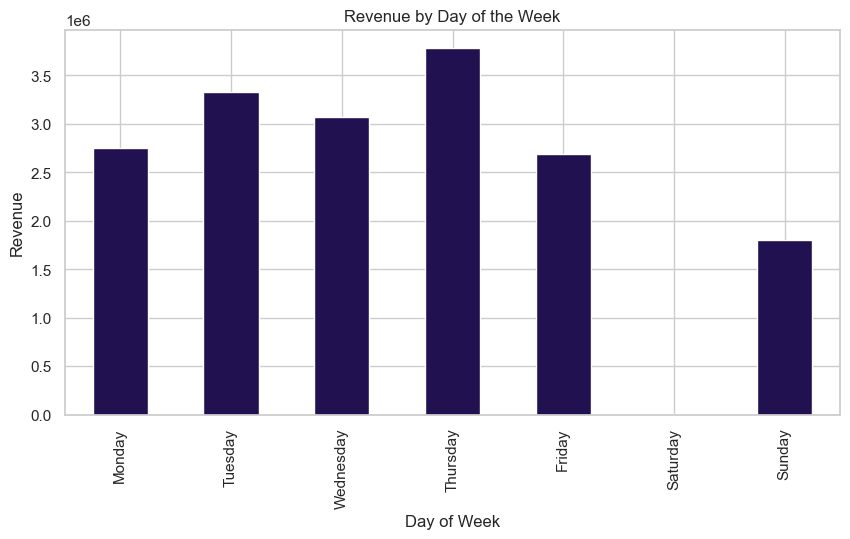

In [ ]:
# =============================
# Phase 2: Exploratory Data Analysis (EDA)
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization style
# sns.set_theme(style="darkgrid", palette="viridis")
sns.set_theme(style="whitegrid", palette="magma")

# 1. Load Cleaned Dataset
df = pd.read_csv("online_retail_cleaned.csv")

# 2. Sales Performance & Seasonality

# Monthly revenue trends
monthly_sales = df.groupby(["Year", "Month"])["TotalPrice"].sum().reset_index()
monthly_sales["YearMonth"] = monthly_sales["Year"].astype(str) + "-" + monthly_sales["Month"].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x="YearMonth", y="TotalPrice", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Sales Revenue")
plt.xlabel("Year-Month")
plt.ylabel("Revenue")
plt.show()

# Day of week sales
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['Weekday'] = df['InvoiceDate'].dt.day_name()  
weekday_sales = df.groupby('Weekday')['TotalPrice'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.figure(figsize=(10,5))
# sns.barplot(x="DayOfWeek", y="TotalPrice", data=df, estimator=sum)
weekday_sales.plot(kind='bar')
plt.title("Revenue by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.show()

# Hourly sales
plt.figure(figsize=(8,5))
sns.barplot(x="Hour", y="TotalPrice", data=df, estimator=sum)
plt.title("Revenue by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.show()

# 3. Product Portfolio Analysis

# Top 10 products by revenue
top_products_revenue = df.groupby("Description")["TotalPrice"].sum().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_products_revenue.values, y=top_products_revenue.index)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.show()

# Top 10 products by quantity
top_products_quantity = df.groupby("Description")["Quantity"].sum().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_products_quantity.values, y=top_products_quantity.index)
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Quantity")
plt.ylabel("Product")
plt.show()

# 4. Geographic Footprint

# ---- Create Revenue column ----
df["Revenue"] = df["Quantity"] * df["Price"]

# ---- Group by Country and sum revenue ----
country_sales = df.groupby("Country", as_index=False)["Revenue"].sum()

# ---- 1. Top 10 countries by revenue ----
top10 = country_sales.sort_values(by="Revenue", ascending=False).head(10)

# ---- 2. UK vs Non-UK percentage ----
total_revenue = country_sales["Revenue"].sum()
uk_revenue = country_sales.loc[country_sales["Country"] == "United Kingdom", "Revenue"].sum()
non_uk_revenue = total_revenue - uk_revenue

uk_percentage = (uk_revenue / total_revenue) * 100
non_uk_percentage = (non_uk_revenue / total_revenue) * 100

print(f"UK Revenue %: {uk_percentage:.2f}%")
print(f"Non-UK Revenue %: {non_uk_percentage:.2f}%")

# ---- 3. Visualization: Top 10 Countries ----
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    x="Revenue",
    y="Country",
    palette="viridis"
)

plt.title("Top 10 Countries by Sales Revenue", fontsize=16, weight="bold")
plt.xlabel("Revenue", fontsize=12)
plt.ylabel("Country", fontsize=12)

# Annotate values on bars
for index, value in enumerate(top10["Revenue"]):
    plt.text(value + 0.02*total_revenue/10, index, f"${value:,.0f}", va="center")

plt.tight_layout()
plt.show()

# ---- 4. UK vs Non-UK Pie chart ----
plt.figure(figsize=(6, 6))
plt.pie(
    [uk_revenue, non_uk_revenue],
    labels=["UK", "Non-UK"],
    autopct="%1.1f%%",
    colors=["#1f77b4", "#ff7f0e"],
    startangle=90,
    wedgeprops={"edgecolor": "white"}
)
plt.title("UK vs. Non-UK Revenue Share", fontsize=14, weight="bold")
plt.show()

# # Top 10 countries by revenue
# country_sales = df.groupby("Country")["TotalPrice"].sum().nlargest(10)

# plt.figure(figsize=(10,6))
# sns.barplot(x=country_sales.values, y=country_sales.index)
# plt.title("Top 10 Countries by Revenue")
# plt.xlabel("Revenue")
# plt.ylabel("Country")
# plt.show()

# # UK vs International sales
# uk_sales = df[df["Country"]=="United Kingdom"]["TotalPrice"].sum()
# intl_sales = df[df["Country"]!="United Kingdom"]["TotalPrice"].sum()

# plt.figure(figsize=(6,6))
# plt.pie([uk_sales, intl_sales], labels=["UK", "International"], autopct="%.1f%%", startangle=90)
# plt.title("UK vs International Sales Share")
# plt.show()


# 5. Customer Segmentation (RFM)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "Invoice": "nunique",
    "TotalPrice": "sum"
}).rename(columns={"InvoiceDate":"Recency","Invoice":"Frequency","TotalPrice":"Monetary"})

# RFM distributions
fig, axes = plt.subplots(1,3, figsize=(18,5))
sns.histplot(rfm["Recency"], bins=30, ax=axes[0])
axes[0].set_title("Recency Distribution")
sns.histplot(rfm["Frequency"], bins=30, ax=axes[1])
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm["Monetary"], bins=30, ax=axes[2])
axes[2].set_title("Monetary Distribution")
plt.show()

# 6. Wholesale vs Retail Analysis

# Define customer type
df["CustomerType"] = np.where(df["Quantity"]>100, "Wholesaler", "Retail")

# Average order value comparison
plt.figure(figsize=(8,5))
sns.barplot(x="CustomerType", y="TotalPrice", data=df, estimator=np.mean)
plt.title("Average Order Value: Wholesalers vs Retail Customers")
plt.xlabel("Customer Type")
plt.ylabel("Average Order Value")
plt.show()

# Order count comparison
plt.figure(figsize=(8,5))
sns.countplot(x="CustomerType", data=df)
plt.title("Order Count: Wholesalers vs Retail Customers")
plt.xlabel("Customer Type")
plt.ylabel("Count")
plt.show()
